In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
features = pd.read_csv('Resources/features.csv')
stores = pd.read_csv("Resources/stores.csv")
train = pd.read_csv("Resources/train.csv")
df = pd.read_csv('Resources/walmart-sales-dataset-of-45stores.csv')

In [3]:
features.shape

(8190, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [9]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [10]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


Dealing with missing values on the features dataset

In [14]:

features = features.fillna({"CPI": features["CPI"].median()})
features = features.fillna({"Unemployment": features["Unemployment"].median()})

In [15]:
for i in range(1, 6):
    features.loc[:, "MarkDown" + str(i)] = (
        features["MarkDown" + str(i)]
        .mask(features["MarkDown" + str(i)] < 0, 0)
        .fillna(0)
    )

In [16]:
# confirming we do not have any missing values.
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Combining the training dataset with the features dataset using merge.

In [17]:
data = pd.merge(train, stores, on="Store", how="left")

In [18]:
data = pd.merge(data, features, on=["Store", "Date"], how="left")

In [19]:
data["Date"] = pd.to_datetime(data["Date"])

In [20]:
data.sort_values(by=["Date"], inplace=True)

In [21]:
data.set_index(data.Date, inplace=True)

In [22]:
data["IsHoliday_x"].isin(data["IsHoliday_y"]).all()

True

In [23]:
data.drop(columns="IsHoliday_x", inplace=True)
data.rename(columns={"IsHoliday_y": "IsHoliday"}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Type          421570 non-null  object        
 5   Size          421570 non-null  int64         
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  I

In [24]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


Seperating out the date columns

In [25]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.isocalendar().week

In [26]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,5
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5


Looking for outliers and bad data

In [27]:
agg_data = (
    data.groupby(["Store", "Dept"])
    .Weekly_Sales.agg(["max", "min", "mean", "median", "std"])
    .reset_index()
)
agg_data.isnull().sum()

Store      0
Dept       0
max        0
min        0
mean       0
median     0
std       37
dtype: int64

In [28]:
store_data = pd.merge(left=data, right=agg_data, on=["Store", "Dept"], how="left")
store_data.dropna(inplace=True)
data = store_data.copy()
del store_data

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values(by=["Date"], inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,...,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,0.0,0.0,...,6.299,False,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095


In [ ]:
data["Total_MarkDown"] = (
    data["MarkDown1"]
    + data["MarkDown2"]
    + data["MarkDown3"]
    + data["MarkDown4"]
    + data["MarkDown5"]
)
data.drop(
    ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"],
    axis=1,
    inplace=True,
)

In [ ]:
numeric_col = [
    "Weekly_Sales",
    "Size",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Total_MarkDown",
]
data_numeric = data[numeric_col].copy()

In [ ]:
data.shape

(421533, 20)

In [ ]:
data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis=1)]
data.shape

(375438, 20)

Neg weekly sales values

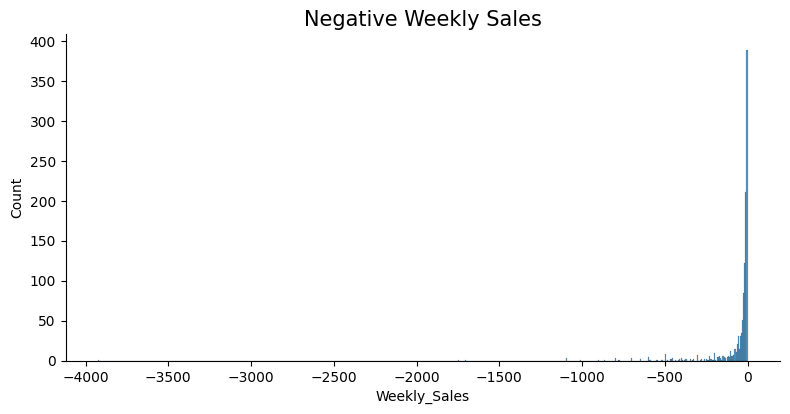

In [ ]:
y = data["Weekly_Sales"][data.Weekly_Sales < 0]
sns.displot(y, height=4, aspect=2)
plt.title("Negative Weekly Sales", fontsize=15)
#plt.savefig("plots/negative_weekly_sales.png")
plt.show()

In [ ]:
data = data[data["Weekly_Sales"] >= 0]

In [ ]:
data.shape

(374247, 20)

In [ ]:
# # Holiday analysis
# holiday = {6:"Super Bowl", 36:"Labor day", 47:"Thanksgiving", 51:"Christmas"}

# #sales average by holiday
# holidays = preprocessed_data[preprocessed_data["Week"].isin([6,36,47,51])]
# holiday_mean = holidays[["Weekly_Sales", "Week"]].groupby("Week").mean().reset_index().sort_values('Weekly_Sales', ascending=False)
# holiday_mean = holiday_mean.rename(columns={"Week":"Holiday"})
# holiday_mean["Holiday"] = holiday_mean["Holiday"].map(holiday)
# holiday_mean

In [ ]:
# fig = px.bar(holiday_mean, x="Holiday", y="Weekly_Sales", 
#              color="Holiday",
#              title = 'Sales average by holiday',
#              template = 'plotly+presentation',
#              text_auto=".2s",
#              color_discrete_sequence = px.colors.qualitative.Pastel)

# fig.update_layout(
#     title={
#         'y':0.92,
#         'x':0.5},
#     font=dict(
#         family='Trebuchet MS',
#         size=15),
#     yaxis_title = 'Sales',
#     xaxis_title = 'Holiday',
# )

# fig.update_traces(textfont_size=14, 
#                   textposition="inside", 
#                   )


# fig.show()


In [ ]:
data["IsHoliday"] = data["IsHoliday"].astype("int")

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374247 entries, 2010-02-05 to 2012-10-26
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           374247 non-null  int64         
 1   Dept            374247 non-null  int64         
 2   Date            374247 non-null  datetime64[ns]
 3   Weekly_Sales    374247 non-null  float64       
 4   Type            374247 non-null  object        
 5   Size            374247 non-null  int64         
 6   Temperature     374247 non-null  float64       
 7   Fuel_Price      374247 non-null  float64       
 8   CPI             374247 non-null  float64       
 9   Unemployment    374247 non-null  float64       
 10  IsHoliday       374247 non-null  int32         
 11  Year            374247 non-null  int32         
 12  Month           374247 non-null  int32         
 13  Week            374247 non-null  UInt32        
 14  max             3742

In [ ]:
data

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std,Total_MarkDown
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,57592.12,14537.37,22513.322937,18535.480,9854.349032,0.00
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,766.93,-9.92,372.655556,371.050,290.954675,0.00
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,2512.14,110.56,876.629441,824.040,307.436056,0.00
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,11990.43,7414.43,9188.915105,9161.970,756.223236,0.00
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,29166.26,4791.74,8607.050490,7571.600,3874.176095,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,2,26,2012-10-26,9258.88,A,202307,69.79,3.506,223.078337,6.170,0,2012,10,43,19679.04,4179.99,9347.725105,8762.990,2825.107609,9678.80
2012-10-26,38,23,2012-10-26,53.12,C,39690,65.95,4.301,131.193097,10.199,0,2012,10,43,289.78,3.50,37.848679,31.365,34.065601,502.88
2012-10-26,27,6,2012-10-26,5339.65,A,204184,58.99,4.071,142.762411,8.000,0,2012,10,43,41005.33,2524.01,7730.729091,6798.780,5178.928257,10969.27


In [ ]:
data.to_csv("./Resources/preprocessed_data.csv")

Visualizing the data

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


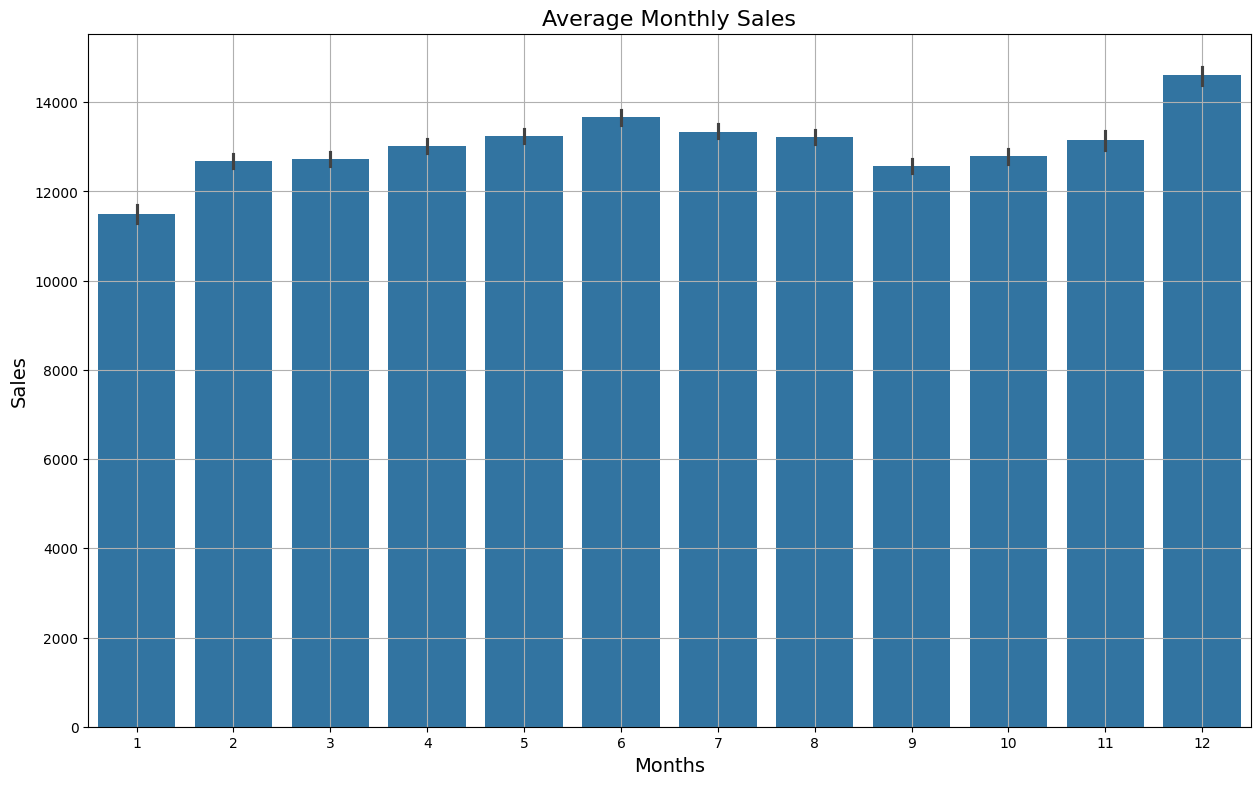

In [ ]:
plt.figure(figsize=(15, 9))
sns.barplot(x="Month", y="Weekly_Sales", data=data)
plt.ylabel("Sales", fontsize=14)
plt.xlabel("Months", fontsize=14)
plt.title("Average Monthly Sales", fontsize=16)
plt.savefig("plots/avg_monthly_sales.png")
plt.grid()

Sales by Month for each year.

In [ ]:
data_monthly = pd.crosstab(
    data["Year"], data["Month"], values=data["Weekly_Sales"], aggfunc="sum"
)
data_monthly

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2010,NaN,1.365986e+08,1.369976e+08,1.753251e+08,1.422677e+08,1.455770e+08,1.776954e+08,1.426176e+08,1.344151e+08,1.687452e+08,1.440445e+08,1.927286e+08
2011,1.170809e+08,1.320987e+08,1.341586e+08,1.710181e+08,1.382097e+08,1.441182e+08,1.762046e+08,1.398143e+08,1.668033e+08,1.375280e+08,1.034907e+08,1.597524e+08
2012,1.172222e+08,8.915290e+07,1.734250e+08,1.479222e+08,1.512280e+08,1.902330e+08,1.458221e+08,1.636039e+08,1.432228e+08,1.480537e+08,NaN,NaN


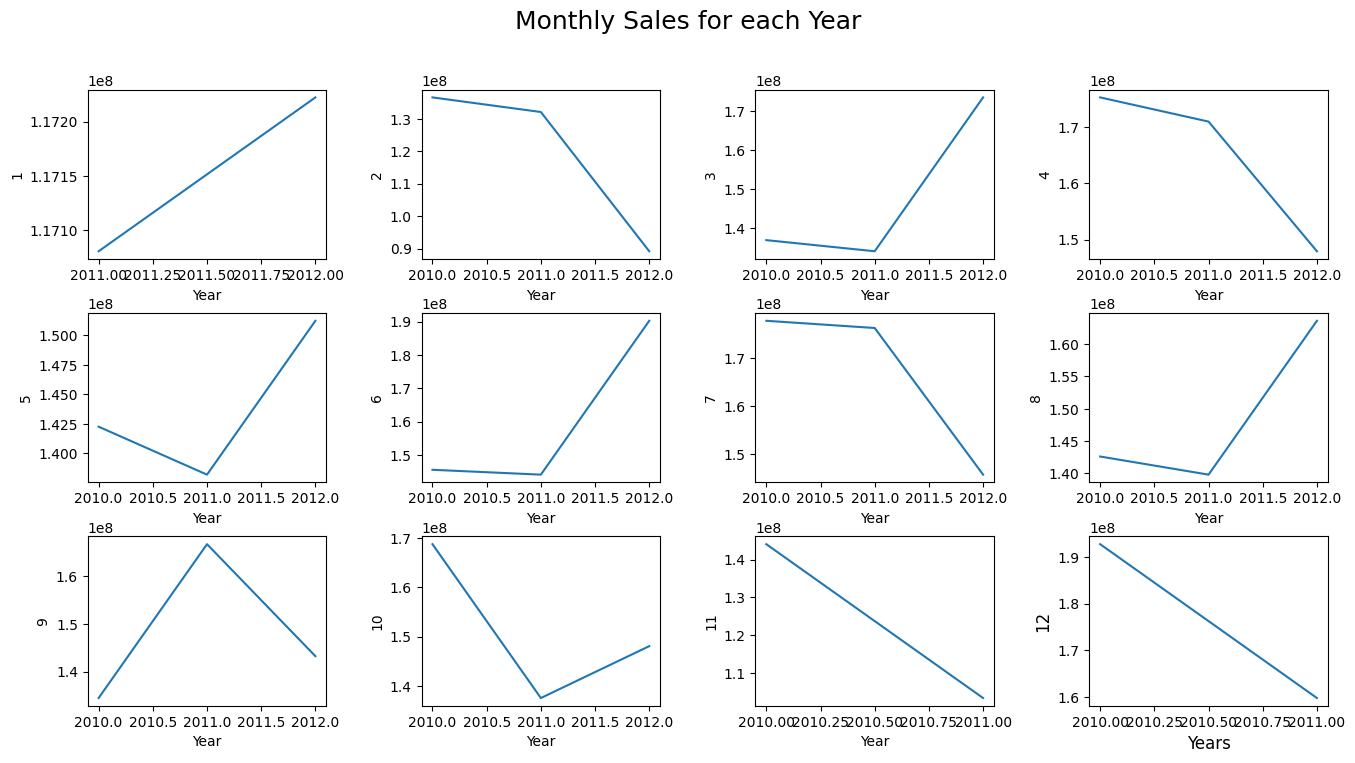

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
plt.suptitle("Monthly Sales for each Year", fontsize=18)
k = 1
for i in range(3):
    for j in range(4):
        sns.lineplot(ax=axes[i, j], data=data_monthly[k])
        plt.subplots_adjust(wspace=0.4, hspace=0.32)
        plt.ylabel(k, fontsize=12)
        plt.xlabel("Years", fontsize=12)
        k += 1

#plt.savefig("plots/monthly_sales_every_year.png")
plt.show()

Avg Weekly Sales by Store 

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


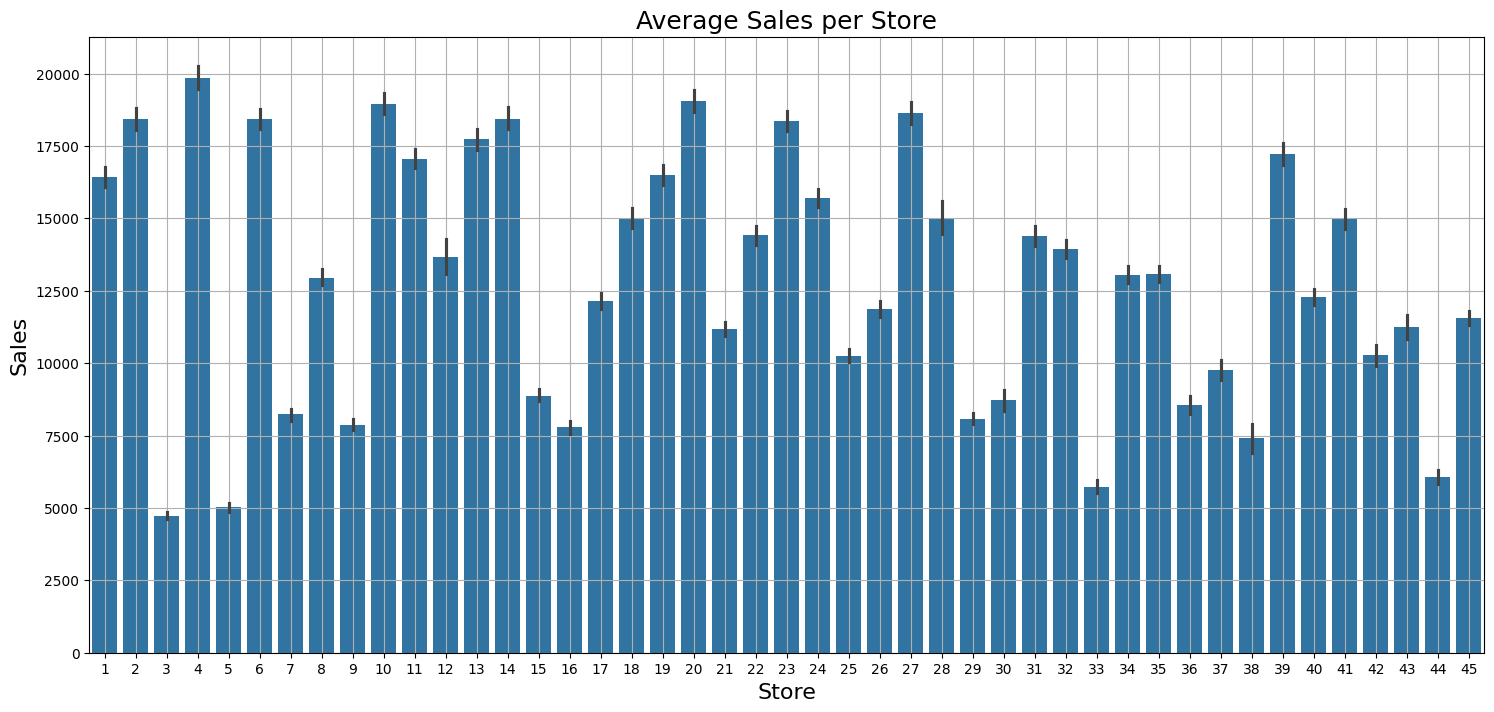

In [ ]:
plt.figure(figsize=(18, 8))
sns.barplot(x="Store", y="Weekly_Sales", data=data)
plt.grid()
plt.title("Average Sales per Store", fontsize=18)
plt.ylabel("Sales", fontsize=16)
plt.xlabel("Store", fontsize=16)
plt.savefig("plots/avg_sales_store.png")
plt.show()

Avg sales by department

In [ ]:
# # Create the "Plots" directory if it doesn't exist
# if not os.path.exists("Plots"):
#     os.makedirs("Plots")

# # Save the plot with the correct file path
# plt.savefig("Plots/avg_sales_dept.png")
# plt.show()

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


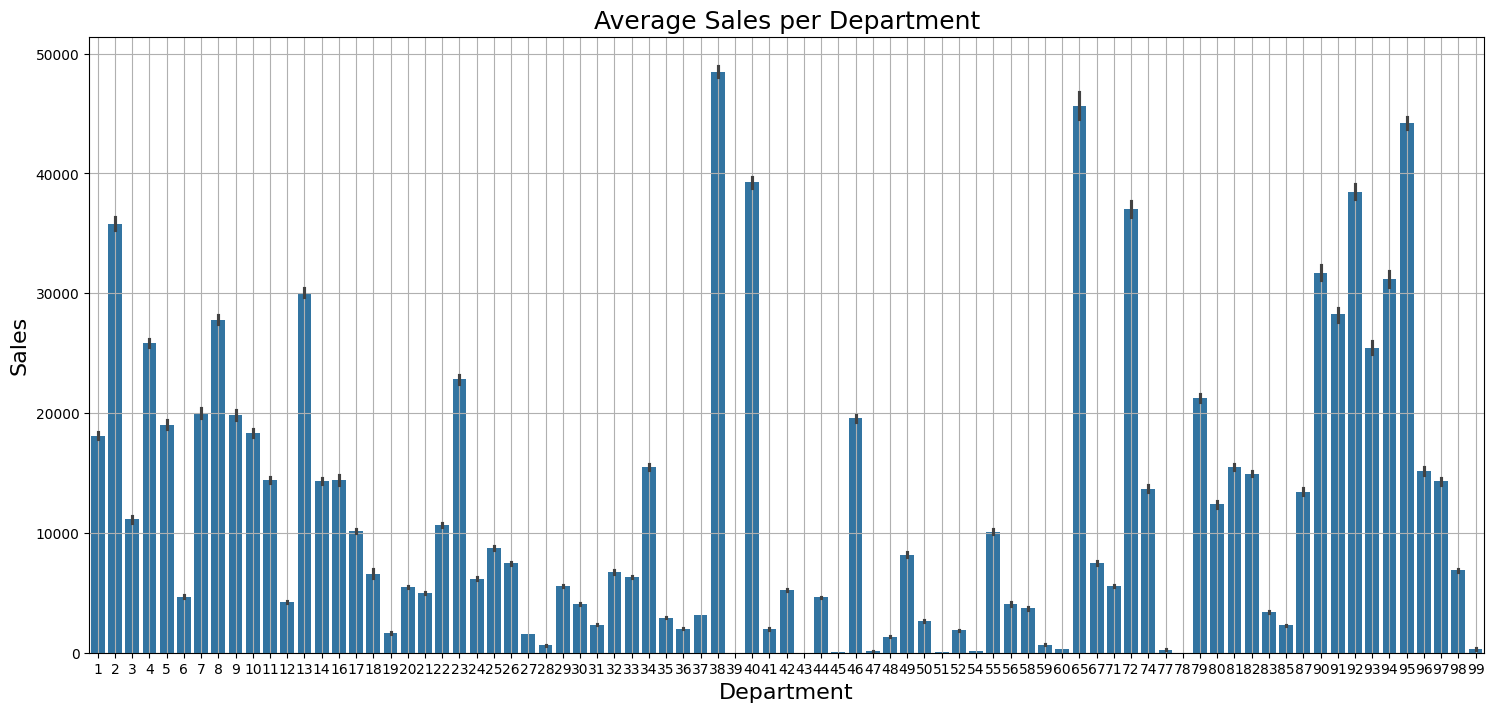

In [ ]:
plt.figure(figsize=(18, 8))
sns.barplot(x="Dept", y="Weekly_Sales", data=data)
plt.grid()
plt.title("Average Sales per Department", fontsize=18)
plt.ylabel("Sales", fontsize=16)
plt.xlabel("Department", fontsize=16)
plt.savefig("Plots/avg_sales_dept.png")
plt.show()

Sales vs Temp

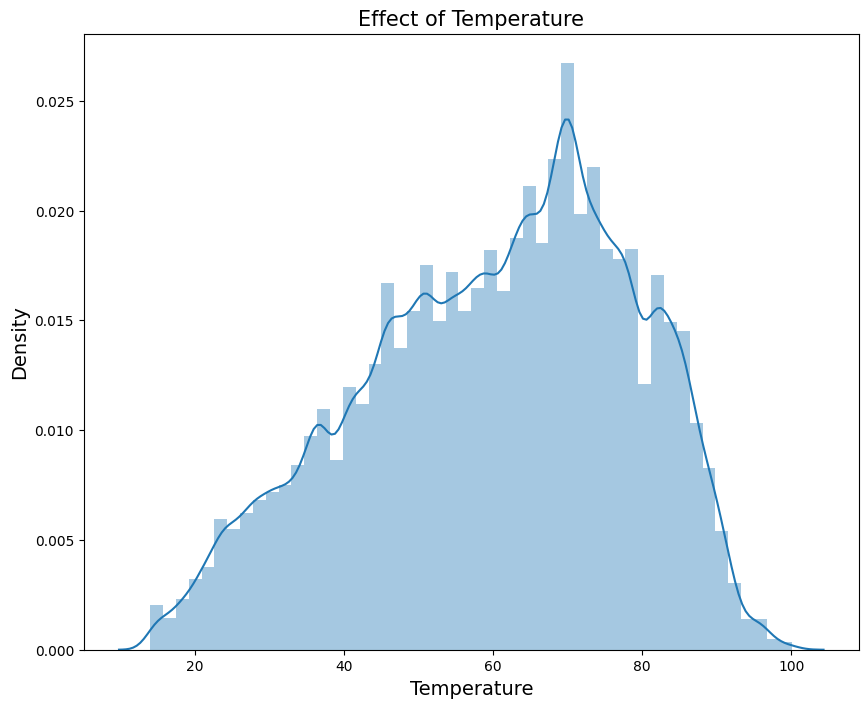

In [ ]:
plt.figure(figsize=(10, 8))
sns.distplot(data["Temperature"])
plt.title("Effect of Temperature", fontsize=15)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Density", fontsize=14)
#plt.savefig("plots/effect_of_temp.png")
plt.show()

Holidays

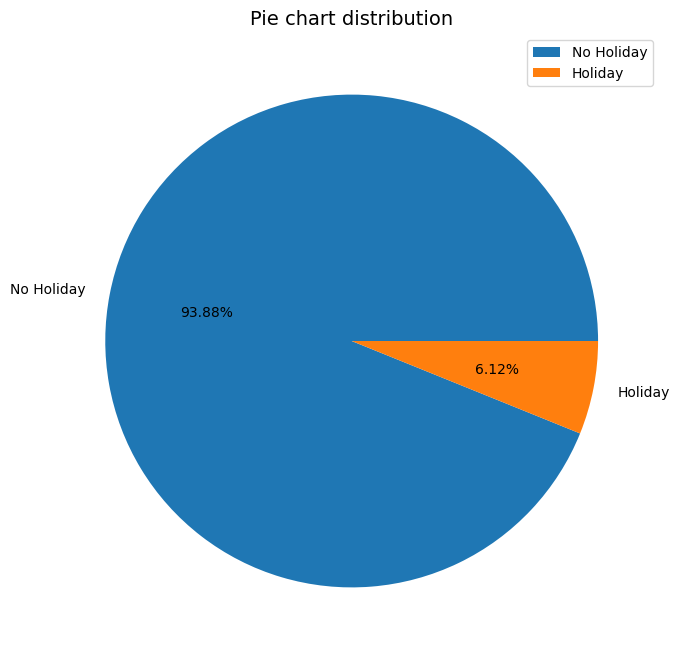

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(
    data["IsHoliday"].value_counts(),
    labels=["No Holiday", "Holiday"],
    autopct="%0.2f%%",
)
plt.title("Pie chart distribution", fontsize=14)
plt.legend()
#plt.savefig("plots/holiday_distribution.png")
plt.show()

Time Series Decomposition- This function is used for time series decomposition, which means breaking down a time series into its underlying components such as trend, seasonality, and residual.  The model="additive". This specifies the decomposition model to be used. In this case, the "additive" model is chosen, which assumes that the observed time series is the sum of the trend, seasonality, and residual components.

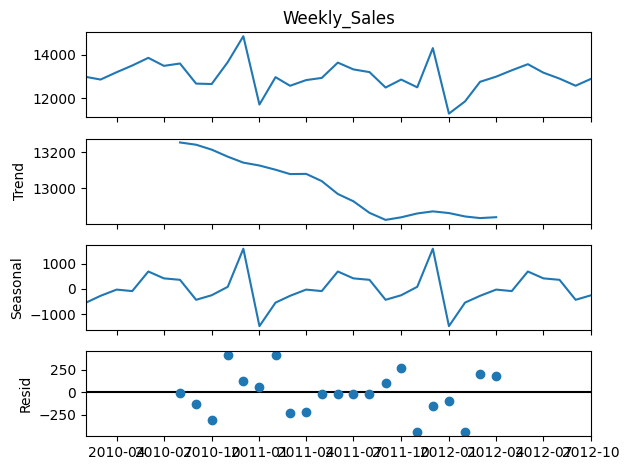

In [ ]:
sm.tsa.seasonal_decompose(
    data["Weekly_Sales"].resample("MS").mean(), model="additive"
).plot()
plt.savefig("plots/seasonal_decompose.png")
plt.show()

Using one hot encoding to convert categorical data to numerical data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374247 entries, 2010-02-05 to 2012-10-26
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           374247 non-null  int64         
 1   Dept            374247 non-null  int64         
 2   Date            374247 non-null  datetime64[ns]
 3   Weekly_Sales    374247 non-null  float64       
 4   Type            374247 non-null  object        
 5   Size            374247 non-null  int64         
 6   Temperature     374247 non-null  float64       
 7   Fuel_Price      374247 non-null  float64       
 8   CPI             374247 non-null  float64       
 9   Unemployment    374247 non-null  float64       
 10  IsHoliday       374247 non-null  int32         
 11  Year            374247 non-null  int32         
 12  Month           374247 non-null  int32         
 13  Week            374247 non-null  UInt32        
 14  max             3742

Category colums are Store, Dept and Type.

In [ ]:
cat_col = ["Store", "Dept", "Type"]
data_cat = data[cat_col].copy()

In [ ]:
data_cat.tail()

,Store,Dept,Type
Date,,,
2012-10-26,2,26,A
2012-10-26,38,23,C
2012-10-26,27,6,A
2012-10-26,36,40,A
2012-10-26,45,98,B


In [ ]:

data_cat = pd.get_dummies(data_cat, columns=cat_col, dtype=int)

data_cat.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
data.shape

(374247, 20)

In [ ]:
data = pd.concat([data, data_cat], axis=1)

In [ ]:
data.drop(columns=cat_col, inplace=True)

In [ ]:
data.drop(columns=["Date"], inplace=True)

Normalizing the data

In [ ]:
num_col = [
    "Weekly_Sales",
    "Size",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Total_MarkDown",
    "max",
    "min",
    "mean",
    "median",
    "std",
]

In [ ]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df, col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = minmax_scale.fit_transform(arr.reshape(len(arr), 1))
    return df

In [ ]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
data = normalization(data.copy(), num_col)

In [ ]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.342576,0.630267,0.328495,0.0501,0.840500,0.508787,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.009188,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0.009537,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0.118953,0.650636,0.233627,0.0501,0.873861,0.291286,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.152888,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


Examing the correlation between the features

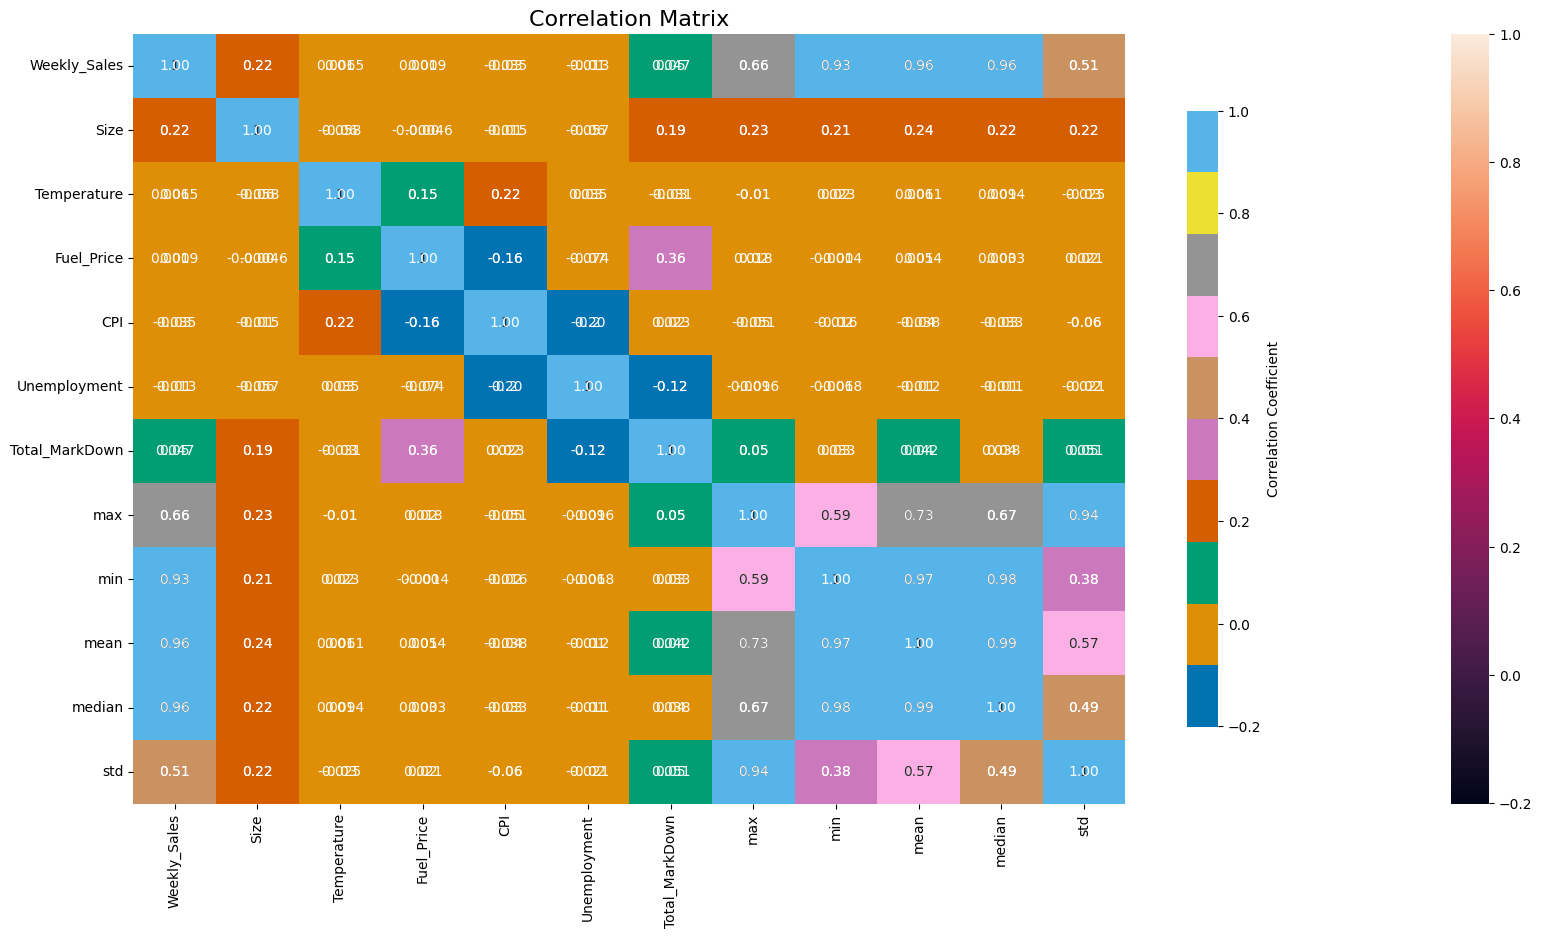

In [ ]:
plt.figure(figsize=(20, 10))
corr = data[num_col].corr()
sns.heatmap(corr, vmax=1.0, annot=True)
cmap = sns.color_palette("colorblind", as_cmap=True)
sns.heatmap(corr, vmax=1.0, annot=True, fmt=".2f", cmap=cmap, cbar_kws={"shrink": .8, "label": "Correlation Coefficient"})
plt.title("Correlation Matrix", fontsize=16)
plt.savefig("plots/correlation_matrix.png")
plt.show()

Recursive Feature Elimination

In [ ]:
feature_col = data.columns.difference(['Weekly_Sales'])
feature_col

Index(['CPI', 'Dept_1', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14',
       'Dept_16', 'Dept_17', 'Dept_18',
       ...
       'Type_B', 'Type_C', 'Unemployment', 'Week', 'Year', 'max', 'mean',
       'median', 'min', 'std'],
      dtype='object', length=144)

In [ ]:

feature_col = ['Store', 'Dept', 'Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
target_col = 'Weekly_Sales'

# Select features and target from the DataFrame
X = data[feature_col]
y = data[target_col]

# Convert 'Date' to datetime if it's not already
X['Date'] = pd.to_datetime(X['Date'])

# Extract useful features from the 'Date' column (optional)
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Week'] = X['Date'].dt.isocalendar().week

# Drop the original 'Date' column as it's no longer needed
X = X.drop(columns=['Date'])

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=0)

# Create the RandomForestRegressor model
radm_clf = RandomForestRegressor(oob_score=True, n_estimators=23)

# Fit the model
radm_clf.fit(X_train, y_train)

# Optionally, make predictions and evaluate the model
y_pred = radm_clf.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


XGBOOST REGRESSION MODEL

Mean Squared Error: 0.04
R-squared: 0.07


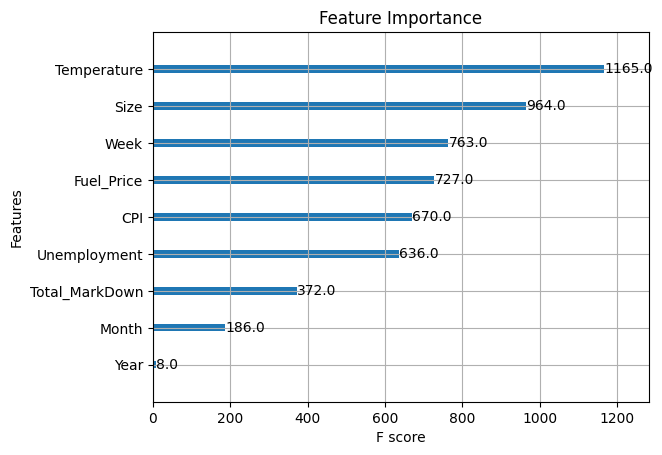

In [ ]:
import xgboost as xgb

#X = data.drop(["Weekly_Sales"], axis=1)  # independent variables
#y = data["Weekly_Sales"]  # dependent variable

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define your features and target variable
feature_cols = [
    "Size",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Total_MarkDown",
    "Year",
    "Month",
    "Week",
]
X = data[feature_cols]
y = data["Weekly_Sales"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.XGBRegressor(X_train, label=y_train.values)
dtest = xgb.XGBRegressor(X_test, label=y_test.values)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Optionally, plot feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.title("Feature Importance")
plt.show()



LINEAR REGRESSION MODEL

In [ ]:
# Select the features and target variable
X = data.drop('Weekly_Sales', axis=1)
y = data['Weekly_Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.00
R-squared: 0.92
